# Настройка

## import

In [ ]:
import os
import pathlib
import copy
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import cv2 
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

tf.get_logger().setLevel('ERROR')

## Класс

In [ ]:
class detector:
  PATH_TO_LABELS = 'G:\\Мой диск\\neural university\\Проект\\mscoco_label_map.pbtxt'
  model_handle = 'G:\\Мой диск\\neural university\\Проект\\ssd_mobilenet_v2_2.tar'
  model_Food = "G:\\Мой диск\\neural university\\Проект\\val_096.h5"
  image = None
  BoxDetect = None
  image_np = None
  result = None


  # Загрузка моделей 
  def __init__(self):
    category_index = label_map_util.create_category_index_from_labelmap(self.PATH_TO_LABELS, use_display_name=True) #https://stackoverflow.com/questions/55591437/attributeerror-module-tensorflow-has-no-attribute-gfile
    self.hub_model = hub.load(self.model_handle)
  

  # Загрузка изображения из интернета 
  def setImage(self,path):

    # Сохранение фото в PIL
    if(path.startswith('http')):
      response = urlopen(path)
      image_data = response.read()
      image_data = BytesIO(image_data)
      self.image = Image.open(image_data)
    else:
      image_data = tf.io.gfile.GFile(path, 'rb').read()
      self.image = Image.open(BytesIO(image_data))

    # Сохранение фото в numpy массиве
    (im_width, im_height) = self.image.size
    self.image_np = np.array(self.image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)


  # Предсказание границ фруктов
  def  predictBox(self):
    results = self.hub_model(self.image_np)
    self.BoxDetect = {key:value.numpy() for key,value in results.items()}



  # Предсказание сежести фруктов
  def DetectFood(self):


    # Выбор фруктов на изображении
    res = np.column_stack((self.BoxDetect['detection_classes'][0],self.BoxDetect['detection_scores'][0],self.BoxDetect['detection_boxes'][0]))
    w = self.image.width
    h = self.image.height
    drow_boxes = []
    boxees_to_dec = []
    for i in res :
      if (i[0] in [52,53,55,57]) & (i[1] > 0.50) :
        boxees_to_dec.append(self.image.crop((int(i[3]*w),int(i[2]*h),int(i[5]*w),int(i[4]*h))))
        drow_boxes.append((int(i[3]*w),int(i[2]*h),int(i[5]*w),int(i[4]*h)))

    # ОБработка вырезанных фото фруктов из исходного изображения
    loaded_model = tf.keras.models.load_model(self.model_Food)
    poc_box = boxees_to_dec.copy()
    for i in range(0,len(poc_box)):
      poc_box[i] = poc_box[i].resize((300,300))
      poc_box[i] = img_to_array(poc_box[i])

    # create image data augmentation generator
    datagen = ImageDataGenerator(
        rescale=1. / 255, #Значения цвета меняем на дробные показания
        fill_mode='nearest', #Заполнение пикселей вне границ ввода
    )
    for i in range(0,len(poc_box)):
      samples = expand_dims(poc_box[i],0)
      poc_box[i] = datagen.flow(samples, batch_size=1)

    # ПРедсказание свежести фруктов
    predicted = []
    for i in poc_box:
      predicted.append(loaded_model.predict(i))
    
    quality = list(map(lambda x: x[0][0]>x[0][1],predicted))

    # ВЫделение фрутов на изображении
    res = np.column_stack((quality,drow_boxes))
    self.result = copy.copy(self.image)
    img_out = ImageDraw.Draw(self.result, "RGBA") 
    for i in res :
      if i[0] == 1 :
        img_out.rectangle((int(i[1]),int(i[2]),int(i[3]),int(i[4])), outline ="green", width = 2)
      else:
        img_out.rectangle((int(i[1]),int(i[2]),int(i[3]),int(i[4])),fill=(255, 0, 0, 60), outline ="red", width = 3)
    return self.result

#Использование

In [ ]:
detec = detector()

In [ ]:
detec.setImage('https://g1.delphi.lv/images/pix/676x385/swLP-gBLZtE/314b554e6eb571bc80-45600750.jpg')

In [ ]:
detec.predictBox()

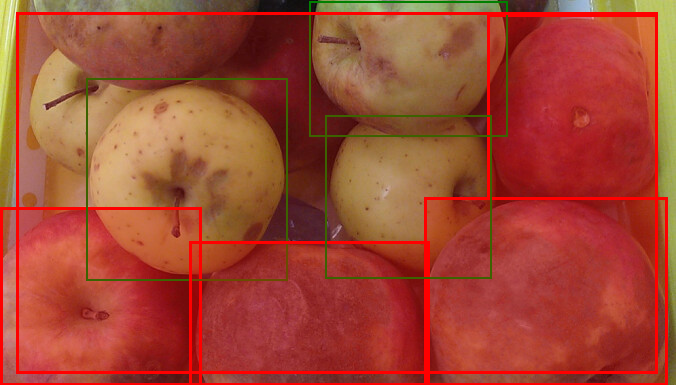

In [ ]:
img = detec.DetectFood()
img